# simSPI Tutorial

Lead author: Luís Henrique Simplício Ribeiro

In this tutorial, we will use the simSPI package to simulate a cryo-EM experiment of the structure of the human 80S ribosome, protein with PDB code 4V6X [1]. In order to run the tests, it is also necessary to have installed the TEM-simulator [2].


<p align="center">
    <img src="4v6x_map.png" width=350 height=350 />
    <p style="text-align: center">
        Figure 1: Human 80S ribosome
    </p>
</p>

[1] https://www.rcsb.org/structure/4v6x

[2] http://tem-simulator.sourceforge.net/

In [1]:
import os
import sys
import warnings

sys.path.append(os.path.dirname(os.getcwd()))
warnings.filterwarnings('ignore')

In [2]:
import torch
import numpy as np
from matplotlib import pyplot as plt, axes as ax

from ioSPI import micrographs
from compSPI import transforms
from simSPI import tem, transfer
from simSPI.linear_simulator import noise_utils, shift_utils


#Helper functions
def plot_image(img, scale, cmap='gray'):
    if img.shape[0] == 1:
         height, width = img.shape[1:]
    else:
        height, width = img.shape
    px = 1/plt.rcParams['figure.dpi']
    plt.figure(figsize=(height*px*scale, width*px*scale))
    plt.imshow(img, cmap)
    plt.axis('off')
    plt.show()

#Create a class from a dict
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

### TEM-simulator

The TEM-simulator is a software developed to simulate a cryo-em experiment. It works by basically passing a file path as parameter. The file which is referenced contains information about the experiment, such the files that will be used and experiments configurations and required outputs.

### TEMSimulator class

There are two configurations files that needed to be provided when creating a `TEMSimulator()` object, they are:

* `path_config.yaml` path of the file that contains the following:
    - pdb_file: the path for the .pdb file
    - mrc_keyword: the name of the .mrc files that will be generated
    - output_dir: where all the generated files will be outputted
    - local_sim_dir: the path on your computer where the TEM-simulator is located<br><br>

* `sim_config.yaml` path of the file that contains details of the simulation, such as beam and optics parameters.


The TEMSimulator class uses extensively functions from `ioSPI`, which provides helper functions for tem.py processing of I/O operations. The main goal of this helper is to fill the `input.inp` file which will be used by the TEM-simulator.

In [3]:
sim_config = 'sim_config.yaml'
path_config = 'path_config.yaml'

In [4]:
temSimulator = tem.TEMSimulator(path_config, sim_config)

In a sample each particle has a different orientation due to the particle rotations. We can can use the function `create_crd_file()` to simulate this behavior. It will create different copies of the molecule in a grid like manner and apply random rotations to them. The positions and Euler angles will be stored in a `.txt` file that will be used by the TEM-simulator.

In [36]:
temSimulator.create_crd_file(5)

We can take a look at the coordinates file that was generated for the TEM-simulator. The program ignores lines starting with #. Therefore, lines 1 and 3 are not being interpreted. The first line that the simulator will read is the second one. It informs that there are 35 particles in (possibly) different locations in the sample, given by 6 different numbers, the $(x,y,z)$ coordinates, and the directions, defined by the Euler angles $(\phi, \theta, \psi)$.

In [5]:
with open(temSimulator.output_path_dict['crd_file'], 'r') as crd_file:
    print(crd_file.read())
    crd_file.close()

# File created by TEM-simulator, version 1.3.
35 6
#            x             y             z           phi         theta           psi  
     -152.8001     -101.3186        0.0000       -7.7488       77.0258       98.5933
     -102.8446     -101.3186        0.0000      -42.5309       61.0747       16.8985
      -52.8892     -101.3186        0.0000      142.1616       31.3872      135.8636
       -2.9337     -101.3186        0.0000     -156.1464       92.4141     -137.1971
       47.0217     -101.3186        0.0000      -87.8095       59.3674      -44.1346
       96.9771     -101.3186        0.0000      -43.1895      131.0101      -48.4261
      146.9326     -101.3186        0.0000        5.0160       19.7981      153.2685
     -152.8001      -51.3631        0.0000     -159.7058       38.9462     -119.9483
     -102.8446      -51.3631        0.0000       13.4604      130.8798      -87.9522
      -52.8892      -51.3631        0.0000       52.6051       62.2495     -158.7561
       -2.93

Now we can use the function `write_inp_file()` to create the input file for the TEM-simulator using the parameters informed in the `path_config.yaml` and `sim_config.yaml` configuration files, and the coordinates file generated before.

In [37]:
temSimulator.write_inp_file()

We can take a look at this input file that will be used by the TEM-simulator.

In [38]:
with open(temSimulator.output_path_dict['inp_file'], 'r') as inp_file:
    print(inp_file.read())
    inp_file.close()

=== simulation ===
generate_micrographs = yes
rand_seed = 4572643253
log_file = 4v6x_randomrot.log
=== sample ===
diameter = 1200
thickness_edge = 100
thickness_center = 100
=== particle toto ===
source = pdb
voxel_size = 0.1
pdb_file_in = 4v6x.pdb
map_file_re_out = None_real.mrc
map_file_im_out = None_imag.mrc
=== particleset ===
particle_type = toto
particle_coords = file
coord_file_in = 4v6x_randomrot.txt
=== geometry ===
gen_tilt_data = yes
tilt_axis = 0
ntilts = 1
theta_start = 0
theta_incr = 0
geom_errors = none
=== electronbeam ===
acc_voltage = 300
energy_spread = 1.3
gen_dose = yes
dose_per_im = 100
dose_sd = 0
=== optics ===
magnification = 81000
cs = 2.7
cc = 2.7
aperture = 50
focal_length = 3.5
cond_ap_angle = 0.1
gen_defocus = yes
defocus_nominal = 1.0
defocus_syst_error = 0.0
defocus_syst_error = 0.0
defocus_file_out = None
=== detector ===
det_pix_x = 5760
det_pix_y = 4092
pixel_size = 5
gain = 2
use_quantization = no
dqe = 0.5
mtf_a = 1.0
mtf_b = 0
mtf_c = 1
mtf_alpha =

Having all the settings of the simulation, we can call the function `run`, which will call the TEM-simulator on your computer, using the local path present in the file `path_config.yaml`.

In [7]:
temSimulator.run()

After running the TEM-simulator you should get a .mrc file as this one.

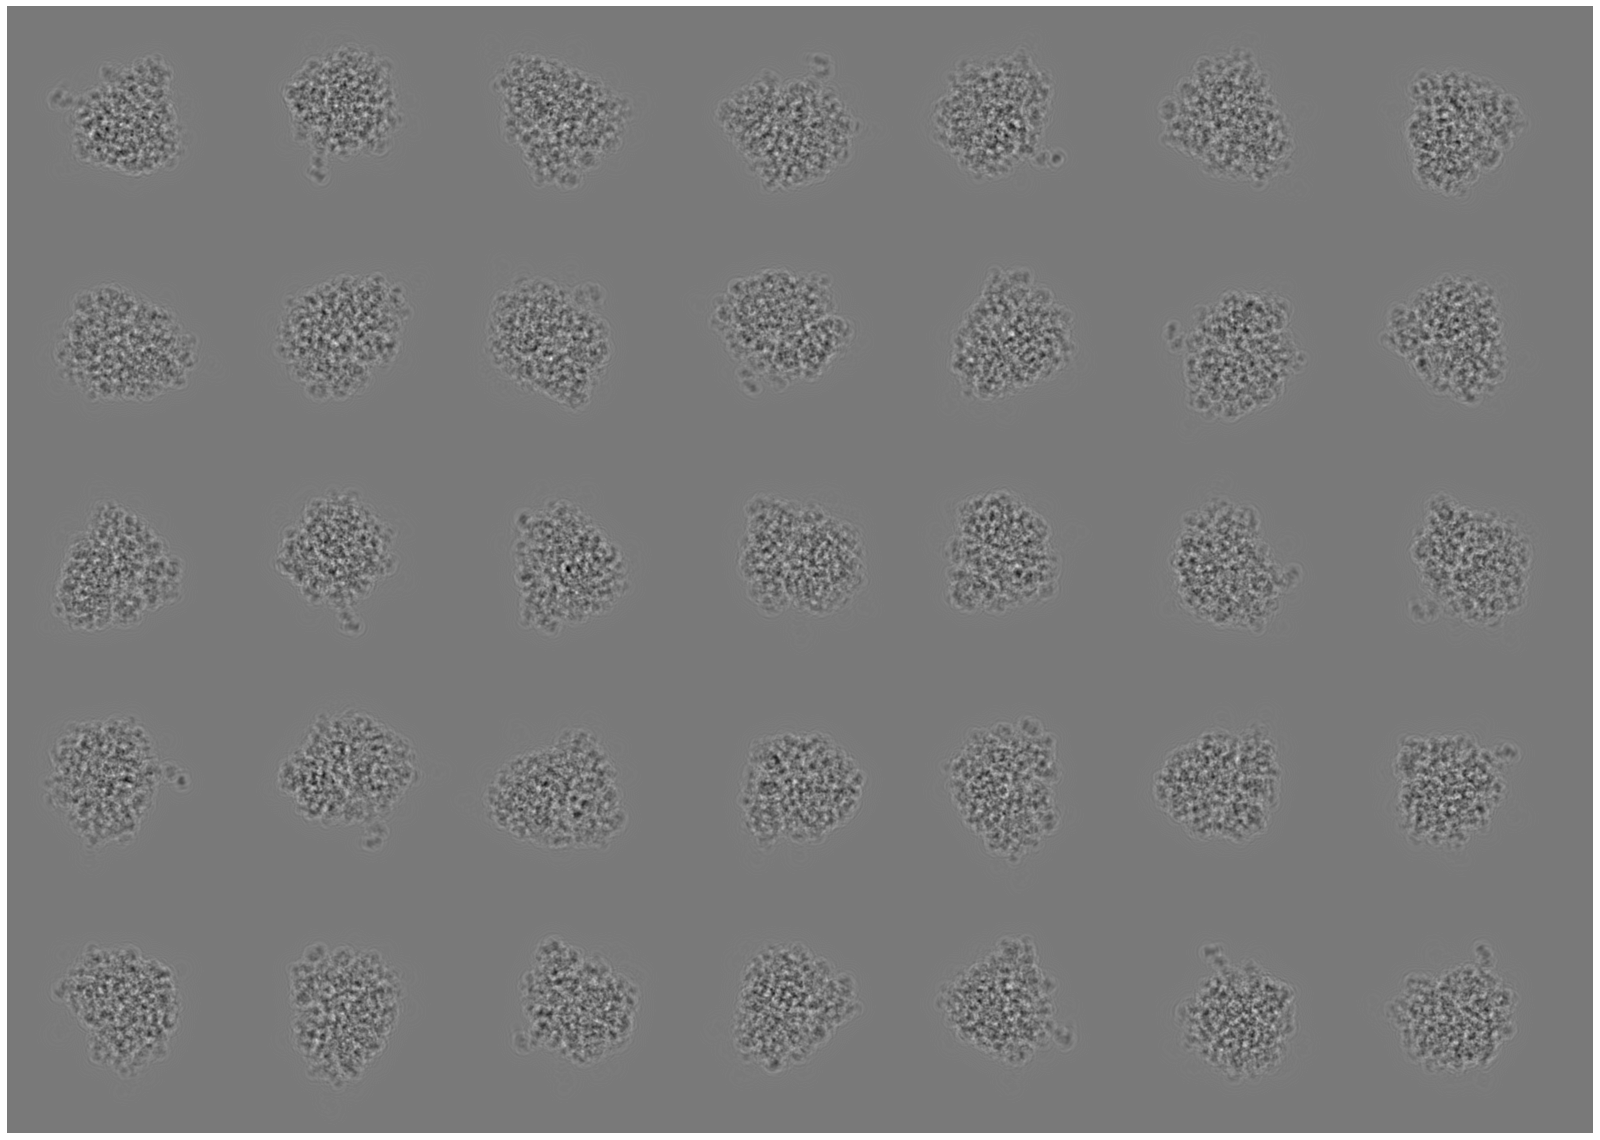

In [8]:
data = micrographs.read_micrograph_from_mrc(temSimulator.output_path_dict["mrc_file"])
micrograph = data[0, ...]

plot_image(micrograph, scale=0.5)

The first thing we are going to do is to extract single particle images from the micrograph. Since the `create_crd_file` function creates the coordinates for the particles in random rotations, but positioned in a grid like manner, it is very easy to recover the images of each of the particles used in the simulation with the `extract_particles` function.

In [9]:
#Extracting the particles
particles = temSimulator.extract_particles(micrograph, 5)
print('{} particles were extracted from the micrograph!'.format(particles.shape[0]))

35 particles were extracted from the micrograph!


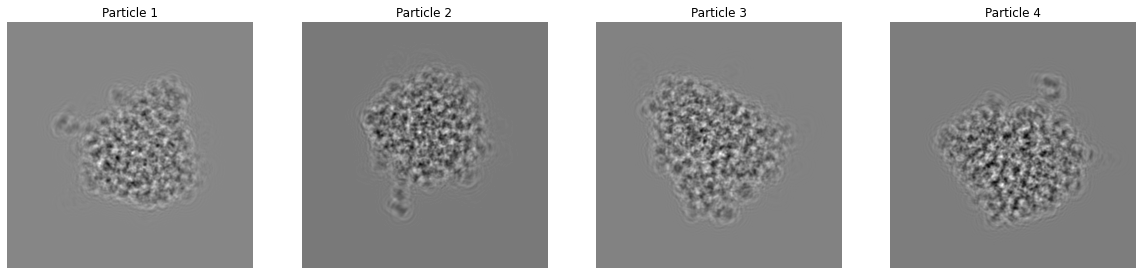

In [10]:
box_size = particles.shape[1]
n_images = 4
px = 1/plt.rcParams['figure.dpi']
scale = 1.8
f, ax = plt.subplots(1,n_images, figsize=(box_size*px*scale,box_size*px*scale))

for i in range(n_images):
    ax[i].imshow(particles[i], cmap='gray')
    ax[i].set_title('Particle {}'.format(i+1))
    ax[i].axis('off')

# Image Formation

We will use the weak phase approximation model to simulate the image formation process in a cryo-EM experiment, where if we have a dataset of particle images $\{X_i\}_{i = 1 \cdots n}$, the $i^{\text{th}}$ image was obtained by the following generative process: $$X_i = \text{PSF}_i * (t_i \circ \Pi_{\text{2D}} \circ R_i)(V) + \epsilon_i,$$ where
* $V$ is the volume representing the electrostatic map of the biological specimen being analysed, in this tutorial, the human 80S ribosome protein. (Note that conformational heterogeneity is not being considered here).
* $R_i$ is a 3D rotation that will define the orientation of the volume for the generated particle $i$. The rotation is usually represented by the Euler Angles.
* $\Pi_{\text{2D}}$ is the 2D projection operator. Which is applied after the volume is rotated.
* $t_i$ represents the 2D translation (or shift in fourier space), it is usually a result of the particle extraction process which may translate the particles off-center by a small amount.
* $\text{PSF}_i$ is the Point Spread Function, which is causes a blurring effect in the final image.
* $\epsilon_i$ is the noise.

We will simulate this process by first generating a "perfect" micrograph, where there is no noise and the PSF does not interfere in the simulation. Additionally, we position the particles on the grid so the process of extracting particles is trivial and does not cause any center shifts. In this ideal scenario every particle image $X_i '$ extracted from the micrograph is simply the result of the following: $$X_i ' = (\Pi_{\text{2D}} \circ R_i)(V)$$

## Translation

The `shift_utils` module from the `linear_simulator` can be used simulate the translation operator $t_i$. Having extracted the particles from the micrograph we can use the `Shift` class to apply a spatial shift in the particle images.

In [11]:
#Defining shift config and params
n_particles = particles.shape[0]
box_size = particles.shape[1]
pixel_size = 5
shift_amount = 10
shift_config = {'side_len': box_size, 'batch_size': n_particles, 'pixel_size': pixel_size}
shift_config = AttrDict(shift_config)

#Sample the shift params from a uniform distribution U[-shift_amount, shift_amount]
shift_params = {'shift_x': torch.FloatTensor(n_particles).uniform_(-shift_amount,shift_amount),
                'shift_y': torch.FloatTensor(n_particles).uniform_(-shift_amount,shift_amount)}

#Instantiate a shift object
shift = shift_utils.Shift(shift_config)

In [12]:
#Shift of each particle
shift_params

{'shift_x': tensor([-4.6298, -7.7924, -0.7120, -6.6528,  3.1084, -6.4131,  8.0061, -3.6150,
         -2.4217,  2.9368, -2.0925,  5.2697,  6.9203, -6.1679,  8.5790, -6.0933,
          8.7770, -4.0190,  1.4126,  4.0105,  6.2502, -9.3418,  8.3668, -3.4479,
         -8.9220,  3.9818, -2.5224, -2.6598, -3.0081,  2.8774,  9.6826, -0.1146,
         -5.7195,  6.4090, -9.7038]),
 'shift_y': tensor([-9.2298, -0.5629,  6.6829,  6.8508, -9.8510,  2.1082, -0.2597,  7.5329,
         -3.0356,  4.8012,  3.6251, -0.0607, -9.9652, -0.8668,  9.4726, -7.6843,
          0.4552,  1.0120, -4.0999,  1.2459, -7.1753, -4.5049, -0.3070, -0.2209,
         -4.9249, -2.1634,  8.0896,  7.5148,  8.8208,  1.4583,  4.4326,  5.0721,
         -8.9178, -7.5528,  0.2707])}

We now calculate the shift in fourier space using the `compSPI` package, which provides fast implementations of the fourier transform with the `transforms` module.

In [13]:
#Calculate the fourier transform of the particles
particles_ft = transforms.primal_to_fourier_2D(torch.tensor(particles))

#Calculate the phases and plot the phase spectrum for the first particle
particles_ft_phase = np.angle(particles_ft)

After computing the fourier transform of the particles we apply the phase shifts and recover the resulting translated images.

In [14]:
#Apply phase-shift in fourier domain
particles_ft = torch.tensor(particles_ft).reshape(n_particles, 1, box_size, box_size)
particles_ft_shift = shift.forward(particles_ft, shift_params)

#Reshape the output and convert it back to a numpy array
particles_ft_shift = particles_ft_shift.reshape(n_particles, box_size, box_size).numpy()

#Calculate the phase spectrum
particles_ft_shift_phase = np.angle(particles_ft_shift)

particles_ft = particles_ft.reshape(n_particles, box_size, box_size).numpy()

#Recover the translated images in spatial domain
particles_tr = transforms.fourier_to_primal_2D(torch.tensor(particles_ft_shift))

(-0.5, 808.5, 808.5, -0.5)

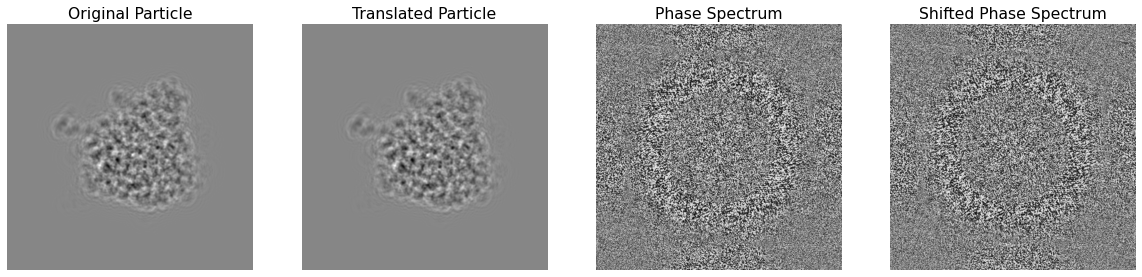

In [15]:
px = 1/plt.rcParams['figure.dpi']
scale = 1.8
plt.rcParams['font.size'] = 13

f, ax = plt.subplots(1,4, figsize=(box_size*px*scale,box_size*px*scale))

i = 0
ax[0].imshow(particles[i], cmap='gray')
ax[0].set_title('Original Particle')
ax[0].axis('off')

ax[1].imshow(np.abs(particles_tr[i]), cmap='gray')
ax[1].set_title('Translated Particle')
ax[1].axis('off')

ax[2].imshow(np.abs(particles_ft_phase[i]), cmap='gray')
ax[2].set_title('Phase Spectrum')
ax[2].axis('off')

ax[3].imshow(np.abs(particles_ft_shift_phase[i]), cmap='gray')
ax[3].set_title('Shifted Phase Spectrum')
ax[3].axis('off')

In [16]:
print('Shift for image {} = ({}, {})'.format(i+1, shift_params['shift_x'][i].item(), shift_params['shift_y'][i].item()))

Shift for image 1 = (-4.62977409362793, -9.2297945022583)


# Transfer

The `transfer` module provides important resources for working with the Contrast Transfer Function (CTF). Including the generation of user defined or random CTFs that can be used to create image particles closer to the ones that would be obtained in a real cryo-EM experiment.

In [21]:
#Define parameters and create the CTF
n_pixels = particles[0].shape[0]
freq_mag_2d, angles_rad = transfer.ctf_freqs(n_pixels, pixel_size)
ctf = transfer.eval_ctf(s=freq_mag_2d, a=angles_rad, def1=1e4, def2=1.1e4, angast=0, phase=0, kv=300, ac=0.1, cs=2.7, bf=0, lp=0)

The Point Spread Function (PSF) causes a blurring effect on the projected particle image, due to imperfections in the electron microscope. If we ignore the noise for now, this effect is described by the convolution of the particle image with the PSF: $$X_i = \text{PSF}_i * (t_i \circ X_i ') $$
We can incorporate this effect calculating the convolution in fourier space: $$\mathcal{F}(\text{PSF}_i * (t_i \circ X_i ')) = \text{CTF}_i \odot \mathcal{F}(t_i \circ X_i '),$$ where $\text{PSF}_i = \mathcal{F}(\text{CTF}_i)^{-1}$.

(-0.5, 808.5, 808.5, -0.5)

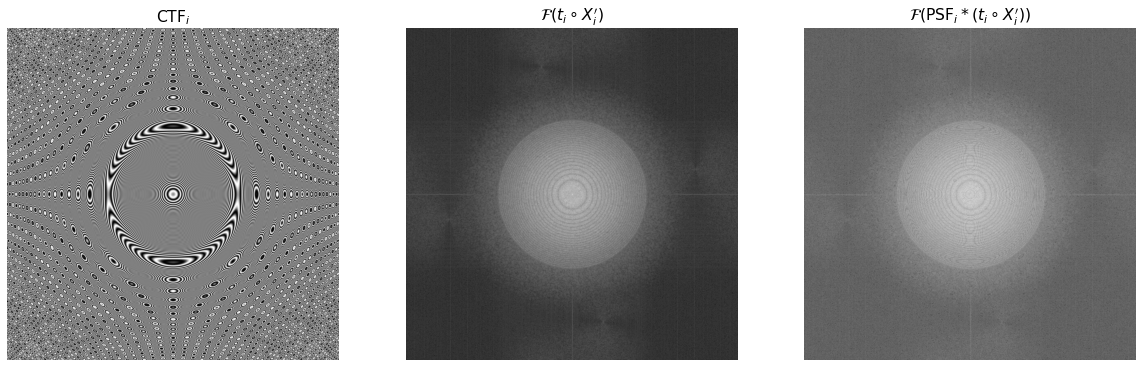

In [22]:
#Calculate the product of the CTF with the fourier transform of the particle
particle_ft_ctf = torch.tensor(ctf) * transforms.primal_to_fourier_2D(particles_tr)

plt.rcParams['font.size'] = 13
px = 1/plt.rcParams['figure.dpi']
scale = 1.8
f, ax = plt.subplots(1,3, figsize=(box_size*px*scale,box_size*px*scale))

ax[0].imshow(ctf, cmap='gray')
ax[0].set_title('$\mathrm{CTF}_i$')
ax[0].axis('off')

ax[1].imshow(np.log(np.abs(particles_ft_shift[0])), cmap='gray')
ax[1].set_title('$\mathcal{F}(t_i \circ X_i \')$')
ax[1].axis('off')

ax[2].imshow(np.log(np.abs(particle_ft_ctf[0])), cmap='gray')
ax[2].set_title('$\mathcal{F}(\mathrm{PSF}_i * (t_i \circ X_i \'))$')
ax[2].axis('off')

Finally, we calculate the inverse fourier transform to get the blurred particle image: $$\text{PSF}_i * (t_i \circ X_i ') = \mathcal{F}^{-1}(  \text{CTF}_i \odot \mathcal{F}(t_i \circ X_i '))$$

(-0.5, 808.5, 808.5, -0.5)

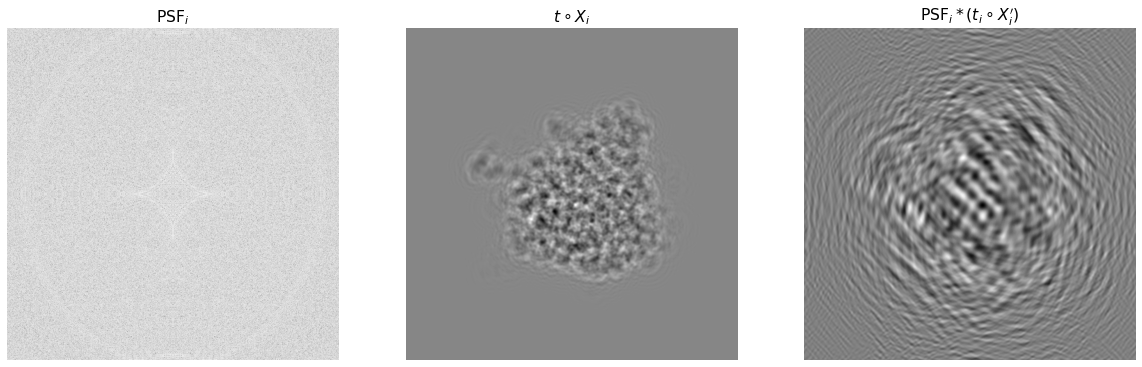

In [23]:
#Calculate the PSF, which is simply the inverse fourier transform of the CTF
psf = transforms.fourier_to_primal_2D(torch.tensor(ctf))

#Calculate the particle convolved with PSF
particle_conv_psf = transforms.fourier_to_primal_2D(particle_ft_ctf)

plt.rcParams['font.size'] = 13
px = 1/plt.rcParams['figure.dpi']
scale = 1.8
f, ax = plt.subplots(1,3, figsize=(box_size*px*scale,box_size*px*scale))

ax[0].imshow(np.log(np.abs(psf)), cmap='gray')
ax[0].set_title('$\mathrm{PSF}_i$')
ax[0].axis('off')

ax[1].imshow(np.abs(particles_tr[0]), cmap='gray')
ax[1].set_title('$t \circ X_i$')
ax[1].axis('off')

ax[2].imshow(np.abs(particle_conv_psf[0]), cmap='gray')
ax[2].set_title('$\mathrm{PSF}_i * (t_i \circ X_i \')$')
ax[2].axis('off')

## Noise

After shifting the particles and convolving them with the PSF, we can add the noise to complete the simulation of the generative process. In order to to so we can instantiate a `Noise` object from `linear_simulator`, which uses PyTorch as backend. This object only receives as input a config `dict`. We then can use the `Noise.forward` function to apply gaussian noise to each of the particles.

In [24]:
#Define the Noise that will be used
noise_config = {'noise': True, 'noise_sigma': 0.05, 'noise_distribution': 'gaussian'}
noise_config = AttrDict(noise_config)

print(noise_config)

{'noise': True, 'noise_sigma': 0.05, 'noise_distribution': 'gaussian'}


In [25]:
#Create Noise object
gaussain_noise = noise_utils.Noise(noise_config)

#Apply the gaussian noise to the particles
particles_final = gaussain_noise.forward(torch.tensor(particle_conv_psf))
particles_final = particles_final.numpy()

Finally, we finish the simulation, getting: $$X_i = \text{PSF}_i * (t_i \circ X_i ') + \epsilon_i,$$

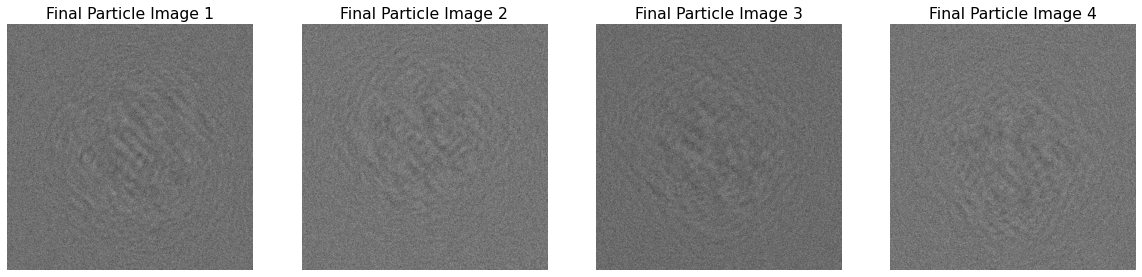

In [26]:
box_size = particles.shape[1]
n_images = 4
px = 1/plt.rcParams['figure.dpi']
scale = 1.8
f, ax = plt.subplots(1,n_images, figsize=(box_size*px*scale,box_size*px*scale))

for i in range(n_images):
    ax[i].imshow(np.abs(particles_final[i]), cmap='gray')
    ax[i].set_title('Final Particle Image {}'.format(i+1))
    ax[i].axis('off')

Summarizing, we showed how to use the `simSPI` library to simulate the image formation model of a cryo-EM experiment.

(-0.5, 808.5, 808.5, -0.5)

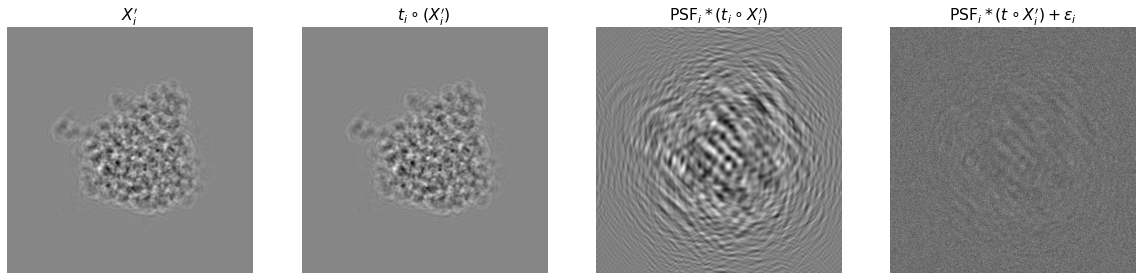

In [27]:
px = 1/plt.rcParams['figure.dpi']
scale = 1.8

f, ax = plt.subplots(1,4, figsize=(box_size*px*scale,box_size*px*scale))

ax[0].imshow(particles[0], cmap='gray')
ax[0].set_title('$X_i \'$')
ax[0].axis('off')

ax[1].imshow(np.abs(particles_tr[0]), cmap='gray')
ax[1].set_title('$t_i \circ (X_i \')$'.format(i))
ax[1].axis('off')

ax[2].imshow(np.abs(particle_conv_psf[0]), cmap='gray')
ax[2].set_title('$\mathrm{PSF}_i * (t_i \circ X_i \')$')
ax[2].axis('off')

ax[3].imshow(np.abs(particles_final[0]), cmap='gray')
ax[3].set_title('$\mathrm{PSF}_i * (t \circ X_i \') + \epsilon_i$')
ax[3].axis('off')